In [153]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from wordcloud import WordCloud
from IPython.display import display
from plotly.subplots import make_subplots
import seaborn as sns
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

## **TABLE OF CONTENTS**:
- [DATASET](#dataset)
- [HOW TO USE](#how_to_use)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [FUNDING SCHEMES](#funding)
  - [DEPARTMENTS](#departments)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES IN DEPTH](#funding_depth)
- [VISUALIZATIONS WHOLE DATASET](#funding_whole)
  - [FUNDING](#funding_whole)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset
2. Input a query 
3. Set parametes
4. Run all
5. Use table of contents to get desired info <br>

Note: some visualizations have extra parameters that can be set, for convenience those are at the specific visualizations.

## **DATASET** <a class="anchor" id="dataset"></a>

In [154]:
DATASET = "../data/nwo_df_projects_eng.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [155]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']
# QUERY = ['universiteit van amsterdam']
# QUERY = ["ai artifical intelligence"]
# QUERY = ["circular cycle raw materials resources materials industrial materials recycling high-quality reuse reuse supply security waste waste chains plastic plastics polymers polymers pet pvc cement concrete concrete glass glass e-waste steel steel biomaterial bioplastic geopolitics manufacturing industry industry industrial"]
# QUERY = ["roman empire alexander the great greece macedonia xerxes"]

## **PARAMETERS** <a class="anchor" id="parameters"></a>

In [156]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
USE_OPENAI_REPERESENTATIONS = True  # set to True to use ChatGPT for generating topic labels

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

# visualizations
SAVE_PLOTS = False  # set to True to save visualizations as PDF files
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [157]:
df_projects = pd.read_pickle(DATASET)

In [158]:
pd.set_option('display.max_columns', None)

print(df_projects.shape)
display(df_projects.head(1))

(14078, 17)


,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314


## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [159]:
# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")

In [160]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/nwo/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    
    # Ensure the directory exists
    save_dir = 'embeddings/nwo/'
    os.makedirs(save_dir, exist_ok=True)
    
    # save embeddings
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [161]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/nwo/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=8,
                        n_gram_range=(1, 2),
                        min_topic_size=8,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # Ensure the directory exists
    save_dir = 'models/nwo/'
    os.makedirs(save_dir, exist_ok=True)

    # save the model
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-14 12:01:57,459 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [162]:
if USE_OPENAI_REPERESENTATIONS is True:
    # add chatgpt labels to the model
    chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
    chatgpt_topic_labels[-1] = "Outlier Topic"
    topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,5207,-1_research_project_new_knowledge,Outlier Topic,"[research, project, new, knowledge, students, ...",[Enhancing Sustainable Research Projects],NaN
1,0,411,0_religious_dutch_history_modern,Religious Interactions in Medieval Islamic Soc...,"[religious, dutch, history, modern, islamic, r...",[Religious Interactions in Medieval Islamic So...,NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [163]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,5207,-1_research_project_new_knowledge,Outlier Topic,"[research, project, new, knowledge, students, ...",[Enhancing Sustainable Research Projects],NaN
1,0,411,0_religious_dutch_history_modern,Religious Interactions in Medieval Islamic Soc...,"[religious, dutch, history, modern, islamic, r...",[Religious Interactions in Medieval Islamic So...,NaN


In [164]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [165]:
topic_model.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

In [166]:
topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

In [167]:
topic_model.visualize_topics(custom_labels=True)

## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [168]:
df_projects = pd.read_pickle(DATASET)
df_projects = df_projects.copy()

In [169]:
df_projects['Topic'] = topics
df_projects.head(1)

,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314,45


In [170]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [171]:
df_projects.head(1)

,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic,Representation,CustomName
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314,45,"[automata, verification, software, rewriting, ...",Unified Theory of Software Correctness


In [172]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

##### Note: these are the topics related to your query.

In [173]:
print(f"Input query: '{QUERY[0]}'\n")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print(f"Topics found (numbers): {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Input query: 'sustainability industry innovation process technology innovation raw materials circularity consumption goods'

Topics found (numbers): [28, 93, 153, 148, 35, 106, 237, 72]

Topics, ranked top to bottom, match with query:

(28): Circular Economy Transition Research
(93): Sustainable Business Model Innovations
(153): Sustainable Plastic Waste Management
(148): Sustainable biobased construction innovations
(35): Circular Textile Innovation
(106): Circular Wood Upcycling
(237): Rubber Devulcanization for Tire Recycling
(72): Thermoset Composite Reuse Research


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

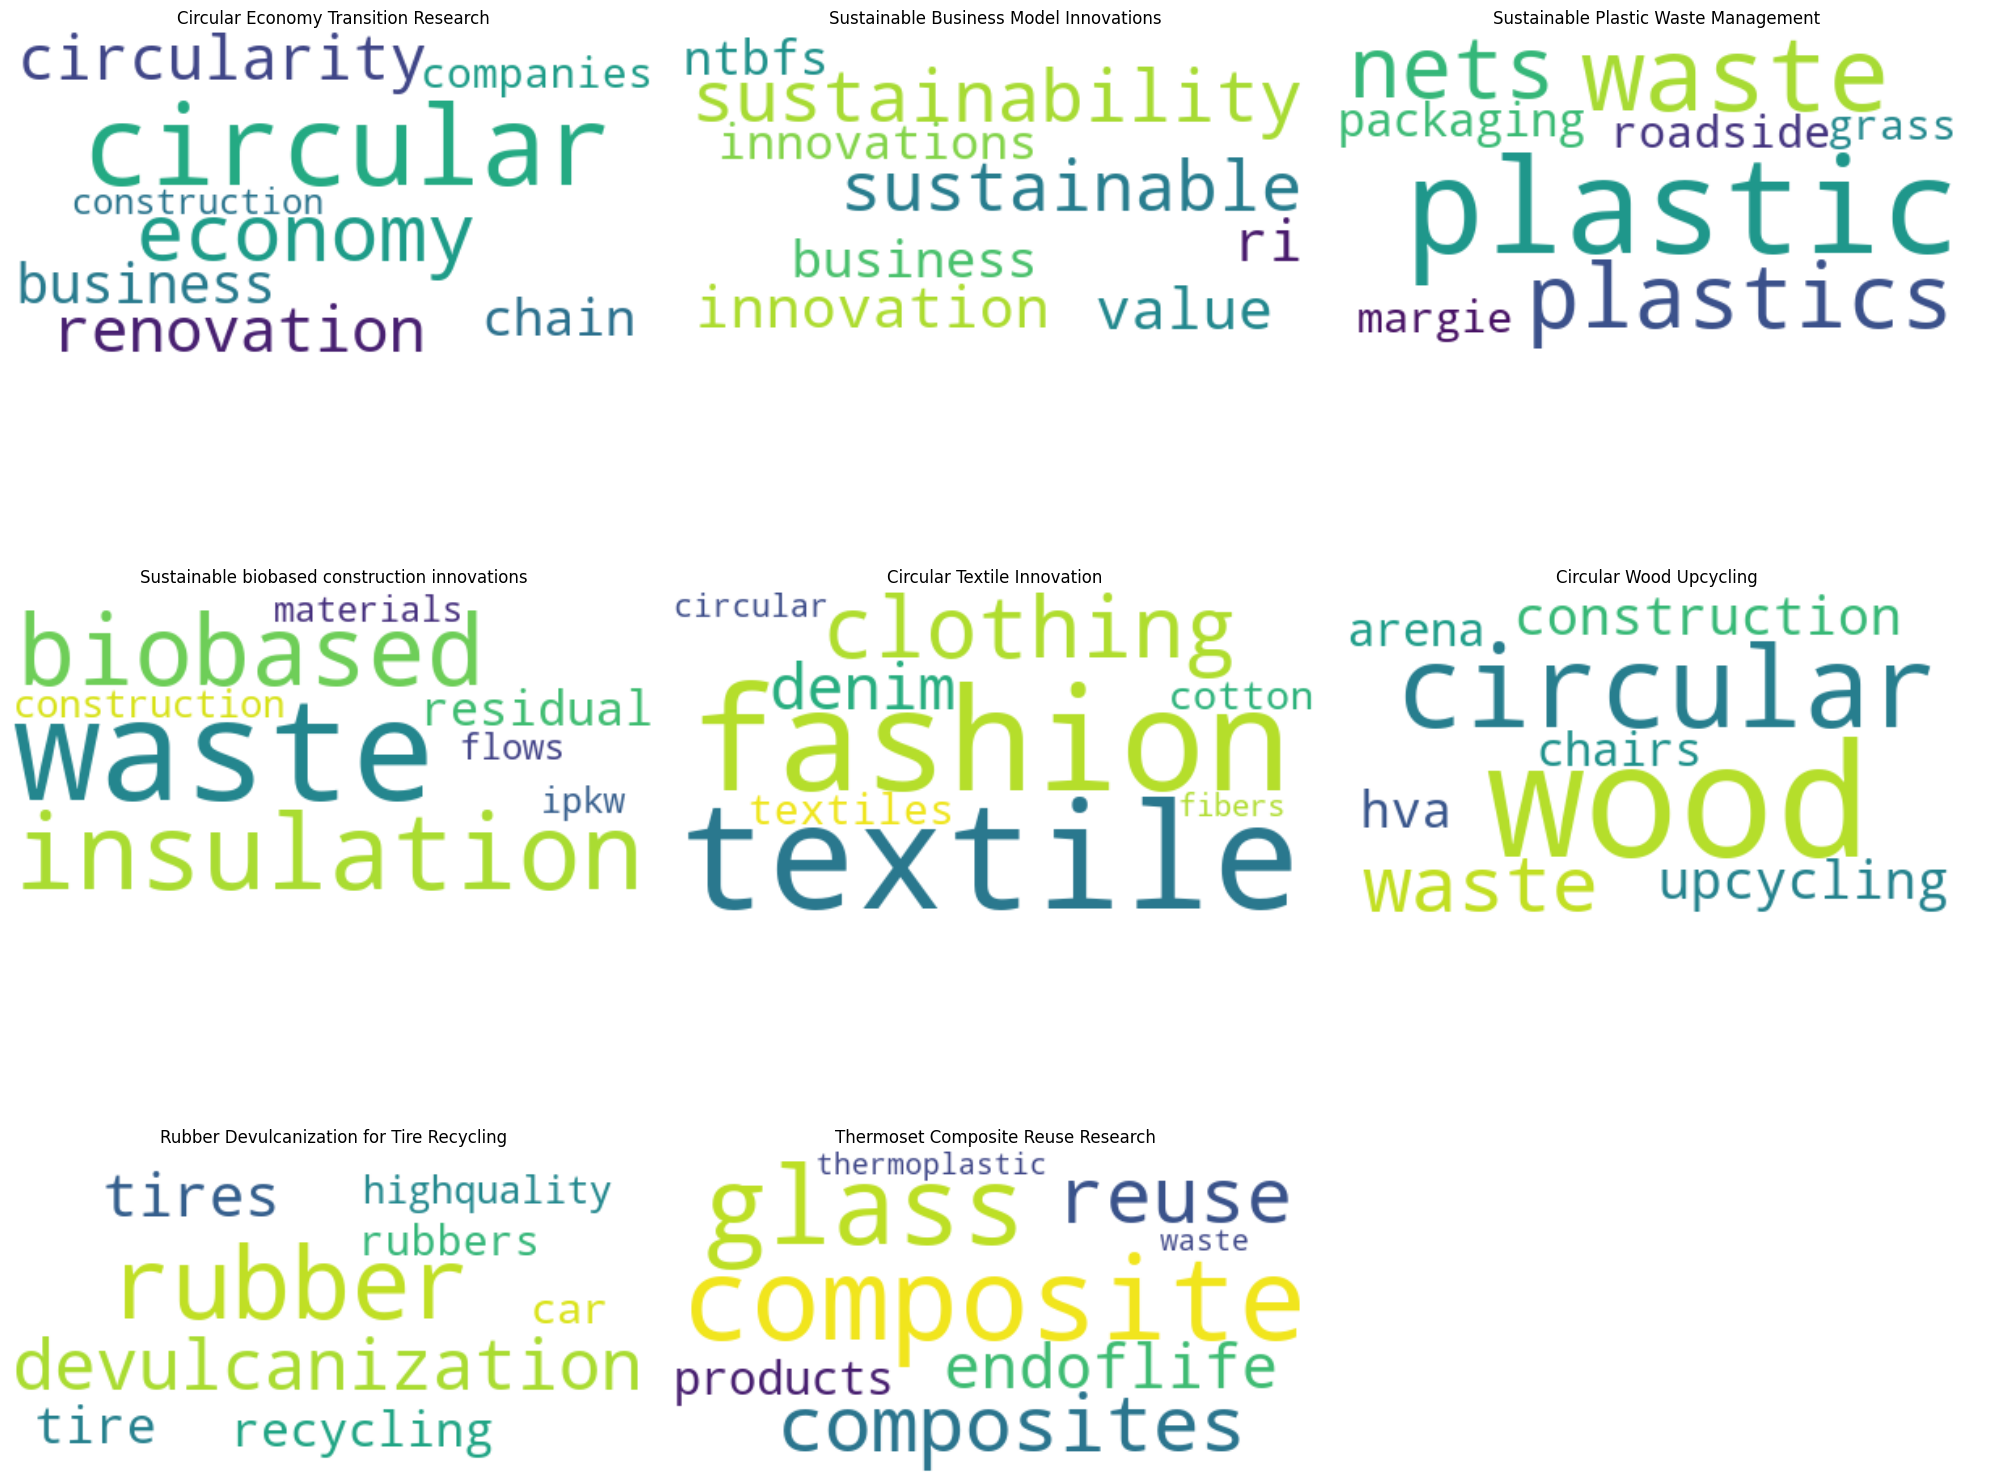

In [174]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3  # maximum three plots per row
rows = (len(TOPICS) + cols - 1) // cols  # calculate the number of rows needed
plt.figure(figsize=(20, 6 * rows))  # adjust figure size as needed

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1)  # create a subplot for each topic
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

##### How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [175]:
print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Topics, ranked top to bottom, match with query:

(28): Circular Economy Transition Research
(93): Sustainable Business Model Innovations
(153): Sustainable Plastic Waste Management
(148): Sustainable biobased construction innovations
(35): Circular Textile Innovation
(106): Circular Wood Upcycling
(237): Rubber Devulcanization for Tire Recycling
(72): Thermoset Composite Reuse Research


In [176]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: 35

In [177]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print(f'Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

Selected topic is: (28): Circular Economy Transition Research


#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

In [178]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # Adjust the threshold based on your needs

This table shows the likelihood that projects belong to Topic (29) Circular Economy Transition Research 


,document,probability
0,circular building installations an important i...,0.88
1,circular business and human capital in limburg...,0.84
2,circular entrepreneurship from concept to prac...,0.83
3,circular building material this research contr...,0.83
4,circular economy in hospitality building a net...,0.82
...,...,...
9086,the impact of neighbourhood effects and socioe...,0.10
9087,costs of democracy the political economy of ca...,0.10
9088,overcoming the faithreason opposition pauline ...,0.10
9089,geometry of the moduli of twisted k surfaces g...,0.10


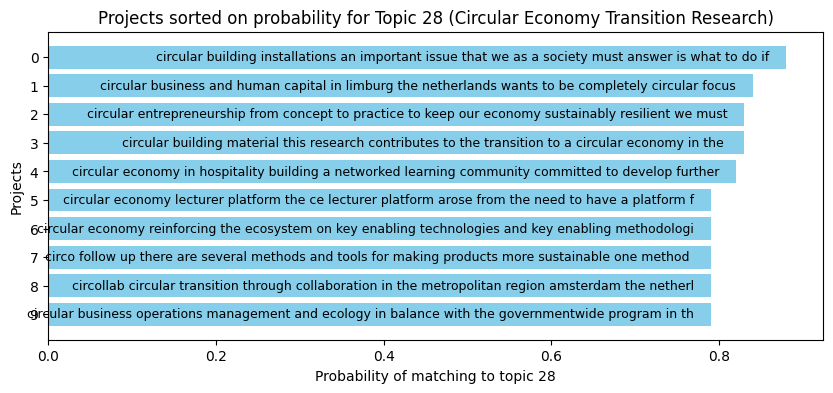

In [179]:
topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print(f'This table shows the likelihood that projects belong to Topic ({TOPIC_INDEX}) {SELECTED_TOPIC_NAME} ')

# Extract the probabilities for the specific topic
specific_topic_probs = probs[:, TOPIC_INDEX]

# Find the indices of documents with a probability above the threshold for the specific topic
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

# Retrieve the documents with the specific topic
docs_with_specific_topic = [docs[i] for i in doc_indices]

# Create a DataFrame with the documents and their probabilities for the specific topic
df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# Sort the DataFrame in descending order by probability
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

display(df_specific_topic)


df_specific_topic_top_n = df_specific_topic.head(10)
# Truncate the 'document' column to 100 characters
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 100)



# Plotting
plt.figure(figsize=(10, 4))  # Change height to a smaller value
bars = plt.barh(df_specific_topic_top_n.index, df_specific_topic_top_n['probability'], color='skyblue')
plt.xlabel(f'Probability of matching to topic {SELECTED_TOPIC_ID}')
plt.ylabel('Projects')
plt.title(f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})')


# Setting yticks to ensure all labels are shown
plt.yticks(ticks=range(len(df_specific_topic_top_n)), labels=df_specific_topic_top_n.index)

# Adding text inside the bars
for bar, doc_text in zip(bars, df_specific_topic_top_n['document']):
    plt.text(
        bar.get_width() - 0.02,  # Adjust the position of the text within the bar
        bar.get_y() + bar.get_height() / 2,
        doc_text,
        ha='right',  # Align text to the right
        va='center',
        fontsize=9,
        color='black',
        wrap=True
    )

plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top
plt.show()

##### Use this cell to read the full summary text of a project based on the figures above

In [180]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [181]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=130)
print(document_text)

circular building installations an important issue that we as a society must answer is what to do if raw materials are no longer
available because our raw material supply is finite the right answer is that we solve it by closing cycles and realizing a
circular economy but how do we do that at the moment we do not yet know what a circular economy should ideally look like there is
a lot of talk and writing about it but there is still too little attention for the application of circular processes in practice
and especially in construction and installation sector which is often called a conservative sector circular applications are still
early in the innovation adoption curve and this sector in particular is a huge consumer of materials and raw materials the
installations in a building are of great importance when renovating buildings it accounts for no less than of the total contract
price relates to installations large profits can therefore be achieved when applying circular principles t

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [182]:
# Extract the topic embeddings
topic_embeddings = topic_model.topic_embeddings_

# Get the embedding of the specific topic
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# Compute the cosine similarity between the specific topic and all other topics
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()

# Convert similarities to distances (1 - similarity)
distances = 1 - similarities

# Round distances to 2 decimal places
distances = np.round(distances, 2)

# Sort the distances and get the corresponding topic indices
sorted_indices = np.argsort(distances)

# Show results
topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

# Rename the 'Count' column to 'document_count'
topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

# Add the distances to the DataFrame
topic_info['distance'] = distances[sorted_indices]

print(f'Deze tabel laat een lijst zien van topics die het dichtstbij topic {SELECTED_TOPIC_ID} liggen op basis van cosine distance')

# Display the updated DataFrame
display(topic_info.head(10))

Deze tabel laat een lijst zien van topics die het dichtstbij topic 28 liggen op basis van cosine distance


,Topic,document_count,Name,CustomName,Representation,distance
29,28,67,28_circular_economy_renovation_circularity,Circular Economy Transition Research,"[circular, economy, renovation, circularity, b...",0.00
107,106,26,106_wood_circular_waste_upcycling,Circular Wood Upcycling,"[wood, circular, waste, upcycling, constructio...",0.21
94,93,29,93_sustainability_sustainable_value_innovation,Sustainable Business Model Innovations,"[sustainability, sustainable, value, innovatio...",0.24
149,148,19,148_waste_insulation_biobased_residual,Sustainable biobased construction innovations,"[waste, insulation, biobased, residual, constr...",0.28
62,61,38,61_logistics_blockchain_chain_supply,Blockchain Logistics Innovation,"[logistics, blockchain, chain, supply, customs...",0.35
63,62,38,62_food_agriculture_circular_dairy,Circular Dairy Farming Solutions,"[food, agriculture, circular, dairy, farming, ...",0.35
18,17,88,17_energy_transition_smart_grid,Sustainable Energy Transition Innovations,"[energy, transition, smart, grid, electricity,...",0.35
0,-1,5207,-1_research_project_new_knowledge,Outlier Topic,"[research, project, new, knowledge, students, ...",0.37
146,145,19,145_innovation_intrapreneurship_flex_entrepren...,Employee-Driven Innovation,"[innovation, intrapreneurship, flex, entrepren...",0.38
162,161,17,161_infrastructure_infrastructures_governance_...,Infrastructure Governance Innovations,"[infrastructure, infrastructures, governance, ...",0.38


In [183]:
# Set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [184]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

##### How to use: Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are lister here again below:

In [185]:
print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Topics, ranked top to bottom, match with query:

(28): Circular Economy Transition Research
(93): Sustainable Business Model Innovations
(153): Sustainable Plastic Waste Management
(148): Sustainable biobased construction innovations
(35): Circular Textile Innovation
(106): Circular Wood Upcycling
(237): Rubber Devulcanization for Tire Recycling
(72): Thermoset Composite Reuse Research


In [186]:
# Choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:3]

In [187]:
print('The selected topics are:')
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    print(f'({topic_id}): {SELECTED_TOPIC_NAME}')

The selected topics are:
(28): Circular Economy Transition Research
(93): Sustainable Business Model Innovations
(153): Sustainable Plastic Waste Management


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [188]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the bar plot
bar_fig = go.Figure()

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        # Adding trace to bar plot
        bar_fig.add_trace(go.Bar(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation
        ))
        
        # Adding trace to line plot
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Update layout for the bar plot
bar_fig.update_layout(
    title='Project Count by Topic Over Time (Bar Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    barmode='group',
    legend_title='CustomName'
)

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the bar plot
bar_fig.show()

# Show the line plot
line_fig.show()

if SAVE_PLOTS is True:
    # Ensure the directory exists
    directory = "saved_plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Format the current time as a string suitable for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    bar_filename = f"{directory}/bar_plot_{timestamp}.png"
    line_filename = f"{directory}/line_plot_{timestamp}.png"

    # Save the bar plot image
    bar_fig.write_image(bar_filename, width=1280, height=720, scale=2)

    # Save the line plot image
    line_fig.write_image(line_filename, width=1280, height=720, scale=2)

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [189]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # Convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # Filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # Group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['project_id'].count().unstack(fill_value=0)
    
    # Ensure all years are included in the index
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # Calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # Get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # Filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    # Create the line plot
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    # Update layout for the line plot
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    # Show the line plot
    line_fig.show()


plot_top_n_schemes(
    df=df_projects,
    column_name='funding_scheme',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

plot_top_n_schemes(
    df=df_projects,
    column_name='sub_department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='sub_department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

#### **DEPARTMENTS** <a class="anchor" id="departments"></a>

In [190]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))


# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of topics per department for the specified topics
topic_counts = filtered_topics.groupby(['department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_departments = [wrap_text(department) for department in topic_data['department']]
    fig.add_trace(go.Bar(
        y=wrapped_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h'
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Department",
    showlegend=False,
    height=600
)

fig.show()

#### **SUB-DEPARTMENTS** <a class="anchor" id="sub_departments"></a>

In [191]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))


# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of topics per department for the specified topics
topic_counts = filtered_topics.groupby(['sub_department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_departments = [wrap_text(department) for department in topic_data['sub_department']]
    fig.add_trace(go.Bar(
        y=wrapped_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h'
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Sub departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Sub department",
    showlegend=False,
    height=600
)

fig.show()

#### **FUNDING SCHEMES IN DEPTH** <a class="anchor" id="funding_depth"></a>

In [192]:
FUNDING_COUNT_THRESHOLD = 3

In [193]:
# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of funding schemes
funding_counts = filtered_topics.groupby('funding_scheme').size().reset_index(name='Frequency')

# Apply the funding count threshold filter
funding_counts = funding_counts[funding_counts['Frequency'] >= FUNDING_COUNT_THRESHOLD]

# Sort the funding counts in descending order
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Prepare data for the bar chart
funding_counts['Funding Scheme'] = funding_counts['funding_scheme']

# Create the horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=funding_counts['Funding Scheme'],
    x=funding_counts['Frequency'],
    orientation='h'
)])

# Update layout
fig.update_layout(
    title=f"Funding Schemes for selected Topics:{SELECTED_TOPIC_IDS}",
    xaxis_title="Frequency",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

In [194]:
MAX_CHARACTERS_FUNDING = 4

In [195]:
# Function to truncate text
def truncate_text(text, max_length):
    return text if len(text) <= max_length else text[:max_length] + '...'

# Assume df_docs is already defined and SELECTED_TOPIC_IDS is a list of topic IDs you're interested in
# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of funding schemes
funding_counts = filtered_topics.groupby('funding_scheme').size().reset_index(name='Frequency')

# Sort the funding counts in descending order
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Prepare data for the bar chart
funding_counts['Funding Scheme'] = funding_counts['funding_scheme'].apply(lambda x: truncate_text(x, MAX_CHARACTERS_FUNDING))

# Sort the Funding Scheme column to maintain order in the bar chart
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Create the horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=funding_counts['Funding Scheme'],
    x=funding_counts['Frequency'],
    orientation='h'
)])

# Update layout
fig.update_layout(
    title=f"Funding Schemes, where the funding scheme name is grouped using max characters: {MAX_CHARACTERS_FUNDING}",
    xaxis_title="Frequency",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

#### **FUNDING** <a class="anchor" id="funding_whole"></a>

In [196]:
# Define maximum characters for truncation
MAX_CHARACTERS = 4
TOP_N_FUNDINGSCHEMES = 12

In [197]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

df_projects = filtered_topics

# Step 1: Truncate funding scheme names
df_projects = df_projects[df_projects['funding_scheme'] != 'Outlier Topic']
df_projects['funding_scheme_truncated'] = df_projects['funding_scheme'].str.slice(0, MAX_CHARACTERS)

# Step 1: Identify the top 12 funding schemes
TOP_N_FUNDINGSCHEMES = 12
top_funding_schemes = df_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Step 2: Create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# Map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# Function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # Filter the topic_counts DataFrame for the specified funding_scheme
    filtered_topic_counts = df_projects[df_projects['funding_scheme_truncated'] == funding_scheme]

    # Count the frequency of topics for the specified funding_scheme
    topic_counts = filtered_topic_counts['Topic'].value_counts().reset_index().head(15)
    topic_counts.columns = ['Topic', 'Frequency']

    # Sort values by frequency
    topic_counts = topic_counts.sort_values(by='Frequency', ascending=True)

    # Add bar trace
    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_counts['Topic']],
        x=topic_counts['Frequency'],
        orientation='h'
    ), row=row, col=col)

# Step 3: Iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

# Update layout
fig.update_layout(
    height=1800,  # Adjust height to fit 6 rows
    width=2000,
    title_text="Topics for Top 12 Funding Schemes",
    showlegend=False  # Hide the legend to avoid clutter
)

fig.show()

In [198]:
MAX_CHARACTERS = 4 # Define maximum characters for truncation
TOP_N_FUNDINGSCHEMES = 12 # Identify the top 12 funding schemes

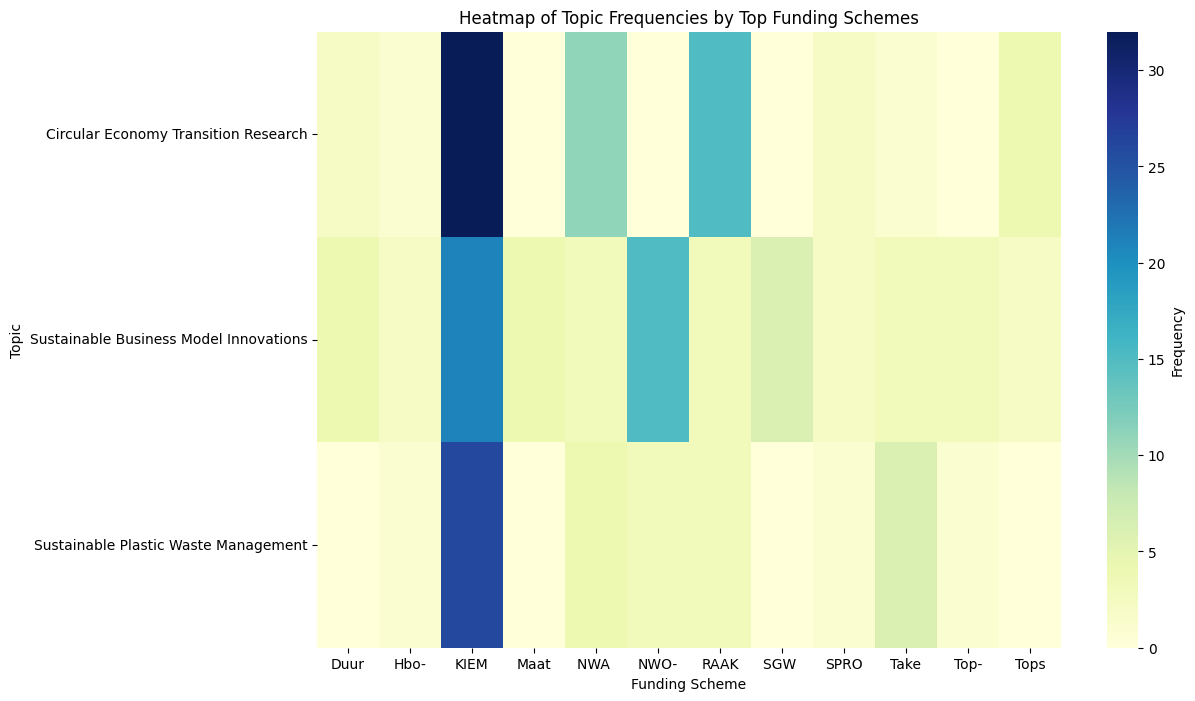

In [199]:
# Remove topics with CustomName 'Outlier Topic'
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding_scheme'].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# Plot heatmap without annotations
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title("Heatmap of Topic Frequencies by Top Funding Schemes")
plt.xlabel("Funding Scheme")
plt.ylabel("Topic")
plt.show()

## **DEEP DIVE INTO TOPIC** <a class="anchor" id="deep_dive"></a>

In [200]:
DEEP_DIVE = False # set to True if you want to run a topic analysis on a specific topic again, by default it is off. Run cell below if set to True.
TOPICS_ZOOM = TOPICS[:1] # choose topic number, by default it is best match

In [201]:
if DEEP_DIVE is True:
    
    df_projects_zoom = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
    print(f'Data shape: {df_projects_zoom.shape}')
    display(df_projects_zoom.head(1))

    docs_zoom = list(df_projects_zoom.text.values) # create stacked list of abstracts
    embeddings_zoom = sentence_model.encode(docs_zoom, show_progress_bar=True)

    topic_model_zoom = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=8,
                        n_gram_range=(1, 2),
                        min_topic_size=4,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics_zoom, probs_zoom = topic_model_zoom.fit_transform(docs_zoom, embeddings_zoom)
    
    if USE_OPENAI_REPERESENTATIONS is True:
        # add chatgpt labels to the model
        chatgpt_topic_labels_zoom = {topics_zoom: " | ".join(list(zip(*values))[0]) for topics_zoom, values in topic_model_zoom.topic_aspects_["OpenAI"].items()}
        chatgpt_topic_labels_zoom[-1] = "Outlier Topic"
        topic_model_zoom.set_topic_labels(chatgpt_topic_labels_zoom)

    display(topic_model_zoom.get_topic_info().head(2))
    display(topic_model_zoom.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400))

## **SOURCES** <a class="anchor" id="sources"></a>
- BERTOPIC EXAMPLE: https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640 <br>
- GENERAL INFO BERTOPIC: https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html <br>
- OPENAI INTEGRATION: https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD